# Copula Notes #

Experimentation with copulas for non-Gaussian state estimation.

Definition of copula.

Example: Gaussian Copula

In [72]:
"""
Import dependencies
"""
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Example 1: Gaussian Copula with Funky Marginals

The Gaussian copula can be used to represent distributions with arbitrary univariate marginals.

To demonstrate this, we construct a distribution with funky univariate marginals. Specifically, we'll consider a joint distribution consisting of the range and bearing to an object. We will specify the range as $\chi^2$-distributed, and the bearing as distributed according to a von-Mises distribution.

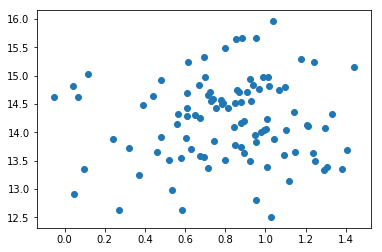

In [57]:
r = np.abs(np.sqrt(np.random.normal(10, 1./np.sqrt(2), size=100)**2 + np.random.normal(10, 1./np.sqrt(2), size=100)**2))

theta = np.random.vonmises(mu=np.pi/4., kappa=10.0, size=100)

plt.scatter(theta, r)

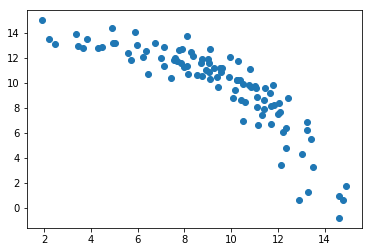

In [62]:
x = r*np.cos(theta)
y = r*np.sin(theta)

plt.scatter(x,y)

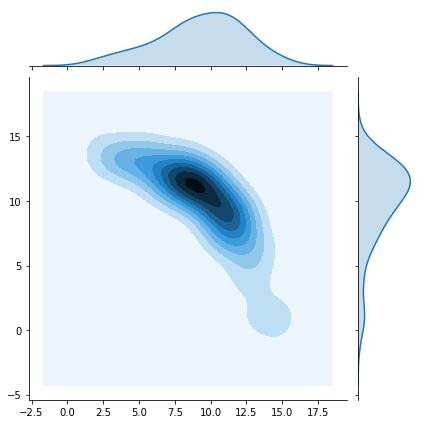

In [63]:
sns.jointplot(x, y, kind='kde', stat_func=None)

In [73]:
norm = stats.norm()

In [1]:
"""
Helper functions for a simple odometry example
"""

M = 100

# Gaussian measurement covariance
u_cov = [[0.001, 0, 0], [0, 0.001, 0], [0, 0, 0.03]]

def observation_model(z_t, x_t):
    """
    Return probability of measurement z_t given state x_t
    """
    return

def compose_tf(x1, x2):
    """
    Compose the transforms represented by x1, x2 (this is o-plus)
    i.e. x1 (+) x2
    """
    x_new = [0.0, 0.0, 0.0]
    x_new[0] = np.cos(x1[2])*x2[0] - np.sin(x1[2])*x2[1] + x1[0]
    x_new[1] = np.sin(x1[2])*x2[0] + np.cos(x1[2])*x2[1] + x1[1]
    x_new[2] = x1[2] + x2[2]
    return x_new

# def inverse_tf(x1, x2):
#     """
#     Return x2 in the frame of x1 (this is o-minus)
#     i.e. x2 (-) x1
#     """
#     x,y,w = x1
#     p1 = np.mat([[np.cos(w), -np.sin(w), x],
#                  [np.sin(w),  np.cos(w), y],
#                  [0,          0,         1]])
#     print p1
#     return np.linalg.inv(p1).dot(np.mat(x2).T).T.ravel()

def motion_model_rel_tf(u_t, x_t, x_prev):
    """
    Return probability of x_t given x_prev and u_t
    """
    print inverse_tf(x_prev, x_t) - u_t
    return stats.multivariate_normal.pdf(inverse_tf(x_prev, x_t), mean=u_t, cov=u_cov)


def sample_motion_model_rel_tf(u_t, x_prev):
    """
    Return a sample from p(x_t | x_t-1, u_t)
    """
    u_samp = np.random.multivariate_normal(u_t, u_cov)
    return compose_tf(x_prev, u_samp)


def particle_filter(X_prev, u_t, z_t=None):
    """
    Run particle filter from state defined by a set of samples X_t-1
    to state X_t (defined by a set of M samples) given control input u_t
    and observation z_t
    """
    X_t_candidates = []
    W_t_candidates = []
    X_t = []
    for m in range(0,M):
        x_t_cand = sample_motion_model_rel_tf(u_t, X_prev[m])
        # print motion_model_rel_tf(u_t, x_t_cand, X_prev[m])
        X_t_candidates.append(x_t_cand)
        if z_t:
            w_t_cand = observation_model(z_t, x_t_cand)
        else:
            w_t_cand = 1.0
        W_t_candidates.append(w_t_cand)
    W_t_candidates = np.array(W_t_candidates)
    W_t_candidates = W_t_candidates / sum(W_t_candidates)
    for m in range(0,M):
        idx = np.random.choice(M, p=W_t_candidates)
        X_t.append(X_t_candidates[idx])
    return np.array(X_t)

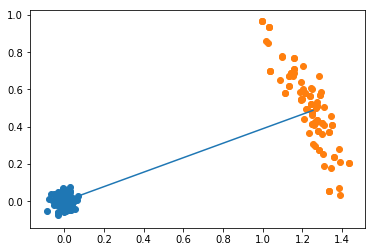

In [2]:
# Number of time steps
T = 1

# Set of control inputs (random walk)
u_walk_mean = [1.0, 0.0, 0.0]
u_walk_cov = [[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]


# define initial state
init_mean = [0, 0, 0]
init_cov = [[0.001, 0, 0], [0, 0.001, 0], [0, 0, 0.03]]


U = []
X_true = [init_mean]
for t in range(0,T):
    u_t = np.random.multivariate_normal(u_walk_mean, u_walk_cov)
    U.append(u_t)
    X_true.append(compose_tf(X_true[t], u_t))

X_true = np.array(X_true)

# initialize probabilistic state
X_prev = np.random.multivariate_normal(init_mean, init_cov, M)

# start particle filtering
for t in range(0, T):
    plt.scatter(X_prev[:,0], X_prev[:,1])
    # X_tilde_prev = copula_fit_transform(X_prev)
    X_prev = particle_filter(X_prev, U[t])
plt.scatter(X_prev[:,0], X_prev[:,1])
plt.plot(X_true[:,0], X_true[:,1])

plt.show()